# 2. Extracción de características

En esta sección vamos a presentar las características que podemos extraer tanto del dominio temporal como del dominio frecuencial de un audio. En base a estas características daremos una intuición de cómo se pueden distinguir géneros musicales a nivel exploratorio/cualitativo, antes de proceder a la próxima sección donde utilizaremos modelos de aprendizaje.

## Importaciones

In [14]:
import librosa

import numpy as np

import matplotlib.pyplot as plt

import IPython.display as ipd
import pandas as pd
import os

___

## 2.1. Explicación de las características

Cuando analizamos una señal de audio, podemos hacerlo desde dos perspectivas principales: el dominio temporal y el dominio frecuencial. Cada uno de estos dominios nos brinda diferentes tipos de información sobre el audio.

### Análisis de una señal de audio: dominio temporal, dominio frecuencial y dominio tempofrecuencial

Hagamos un breve repaso sobre los distintos dominios en los que podemos analizar una señal.

**Dominio temporal: tiempo vs amplitud**

Cuando analizamos el dominio temporal de una señal estamos analizando cómo varía la amplitud de la señal de audio a lo largo del tiempo ("la intensidad de la señal en cada momento"). En este caso:
* **Eje X - tiempo**. El eje horizontal representa el avance temporal medido en segundos.
* **Eje Y - amplitud**. El eje vertical representa la amplitud de la señal, es decir, la desviación de la onda con respecto al eje central. En el dominio temporal se mide como un valor sin dimensiones (adimensional) que oscila entre -1 y 1 en formatos normalizados o como una señal de número entero (por ejemplo, entre -32768 y 32767 señales para 16-bit) en formatos no normalizados. Representa la fuerza o intensidad de la señal.

**Dominio frecuencial: frecuencia vs magnitud**

Cuando analizamos el dominio frecuencial de una señal, estamos analizando la magnitud de cada frencuencia de la señal. En este caso:

* **Eje X - frecuencia.** El eje horizontal representa las frecuencias presentes en la señal, medidas en Hertz (Hz). 
* **Eje Y - magnitud/amplitud.** El eje vertical representa la magnitud de cada frecuencia. Es el módulo del número complejo que representa la contribución de cada frecuencia a la señal global.

Este gráfico representa de forma clara la dicotomía entre ambos dominios.

<img src="img/NB2_timeFreqDomain.png" width="600"/>

*Figura: Dominio temporal vs dominio frecuencial. Fuente: [[1]](https://studyelectrical.com/2023/05/time-domain-analysis-vs-frequency-domain-analysis.html)*

Veamos a continuación un ejemplo práctico utilizando un audio de ejemplo del corpus CCMUSIC:

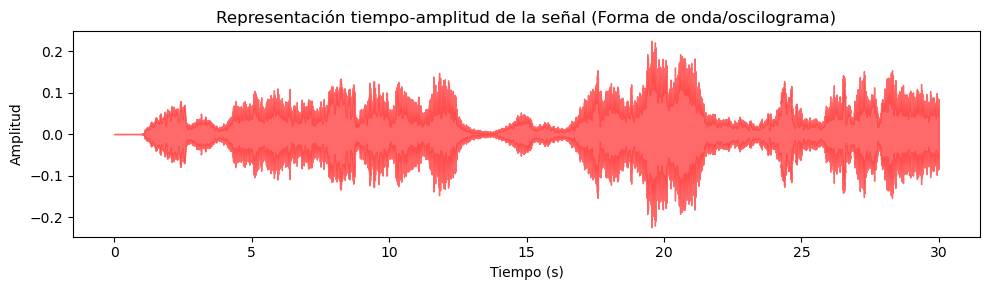

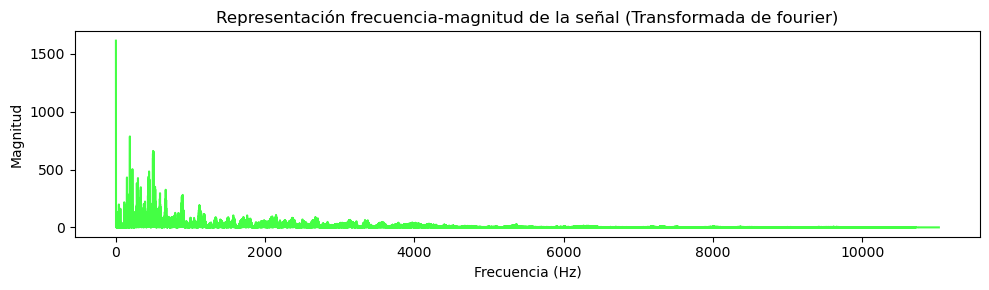

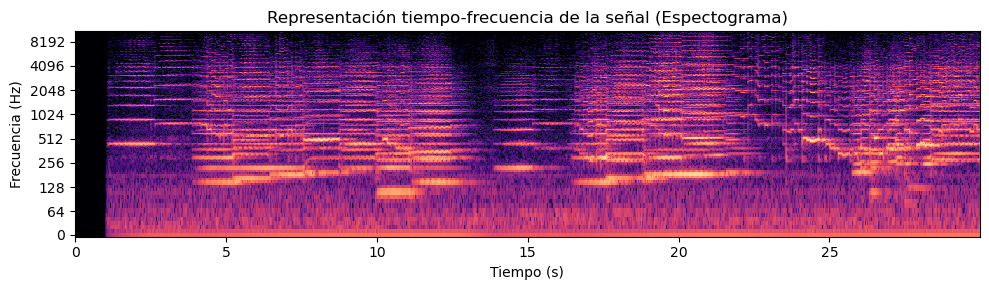

In [15]:
file_ejemplo = "ccmusic/train/audios/audio_train_653.wav"
audio, sr = librosa.load(file_ejemplo, sr=None, mono=True)

# Reproducir el audio
ipd.display(ipd.Audio(audio, rate=sr))

# Dominio temporal
plt.figure(figsize=(10, 3))
librosa.display.waveshow(audio, sr=sr, color="#f44", alpha=0.8)
plt.title("Representación tiempo-amplitud de la señal (Forma de onda/oscilograma)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.tight_layout()
plt.show()

# Dominio frecuencial
fft = np.fft.fft(audio)
frequencies = np.fft.fftfreq(len(fft), 1/sr) # *** Explicación abajo ***
magnitude = np.abs(fft)

plt.figure(figsize=(10, 3))
plt.plot(frequencies[:len(frequencies)//2], magnitude[:len(frequencies)//2], color="#4f4") # Representamos solo la mitad dado que el gráfico es simétrico
plt.title("Representación frecuencia-magnitud de la señal (Transformada de fourier)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.tight_layout()
plt.show()

# Frecuencia + tipo
D = np.abs(librosa.stft(audio))
plt.figure(figsize=(10, 3))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.title("Representación tiempo-frecuencia de la señal (Espectograma)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.tight_layout()
plt.show()

# *** Explicación ***
# np.fft.fftfreq genera un array de frecuencias que corresponde a los componentes de la transformada de Fourier.
# El primer argumento es la longitud de la transformada (igual a la longitud de la señal original).
# El segundo argumento, 1/sr, es el intervalo de tiempo entre muestras, que es el inverso de la tasa de muestreo (sr).
# Esto produce un array de frecuencias que se corresponde con los índices del resultado de np.fft.fft, permitiendo
# visualizar el espectro de frecuencias en Hertz.# 

### Segmentación en bloques

### Características del dominio temporal

* **Amplitude Envelope (AE)**:
    - La envolvente de una señal proporciona una representación más suave de su amplitud, lo que nos permite visualizar mejor cómo varía la intensidad de la señal a lo largo del tiempo.

    - Intuitivamente, es como representar el borde del oscilograma.

    - Matemáticamente, se calcula agrupando el oscilograma en $K$ bloques temporales. Para cada bloque temporal o *frame*, en lugar de tomar todos los valores de amplitud, se toma el máximo (dando esa impresión de borde en la representación final).  
    Esto queda representado por la siguiente fórmula, donde \(AE_k\) es la envolvente de amplitud del bloque \(k\), $F$ es el tamaño del bloque, y \(s(i)\) es la señal en el índice \(i\).
    $$AE_k = \max_{i=kF}^{(k+1)F - 1} s(i)$$

In [16]:
# def amplitude_envelope(signal,frame_size=1024,hop_length=512):
#     F=frame_size
#     H=hop_length
#     N=signal.shape[0]
#     return np.array([max(signal[k:k+F]) for k in range(0, N, H)])

### Características del dominio frecuencial

* **Band Energy Ratio (BER)**:
    - El BER mide la energía de la señal en diferentes bandas de frecuencia.
    - Es útil para distinguir entre sonidos graves y agudos.

* **Spectral Centroid**:
    - El *Spectral Centroid* indica el "centro de masa" del espectro de frecuencia.
    - Es un indicador de qué tan "brillante" o "oscuro" es el sonido.

* **Spectral Bandwidth**:
    - El *Spectral Bandwidth* mide la dispersión de las frecuencias.
    - Es útil para distinguir entre sonidos con diferentes texturas.

____

## 2.2. Caso práctico: las características distinguen géneros muscicales


Las características extraídas del audio como las que hemos descrito anteriormente, son herramientas esenciales en el análisis y clasificación de música. Estas medidas pueden ser especialmente útiles para diferenciar entre distintos tipos y subgéneros de música, como la música clásica frente a otros géneros no clásicos, así como para identificar subgéneros dentro de cada categoría principal. Veamos más en profundidad el significado de cada una de estas características y cómo se calculan.


## RMS

La RMS (Root Mean Square) de una señal sirve para estimar la energía de la señal en distitnos puntos del tiempo, lo que puede ayudar a detectar silencios y la dinámica de la señal. Para calcular el RMS de una señal $s(i)$ segmentada en $k$ bloques de tamaño $F$, se calcula:

$$RMS_k=\sqrt{\frac{1}{F} \cdot \sum_{i=k \cdot F}^{(k+1)\cdot F-1}{s(i)^2}}$$


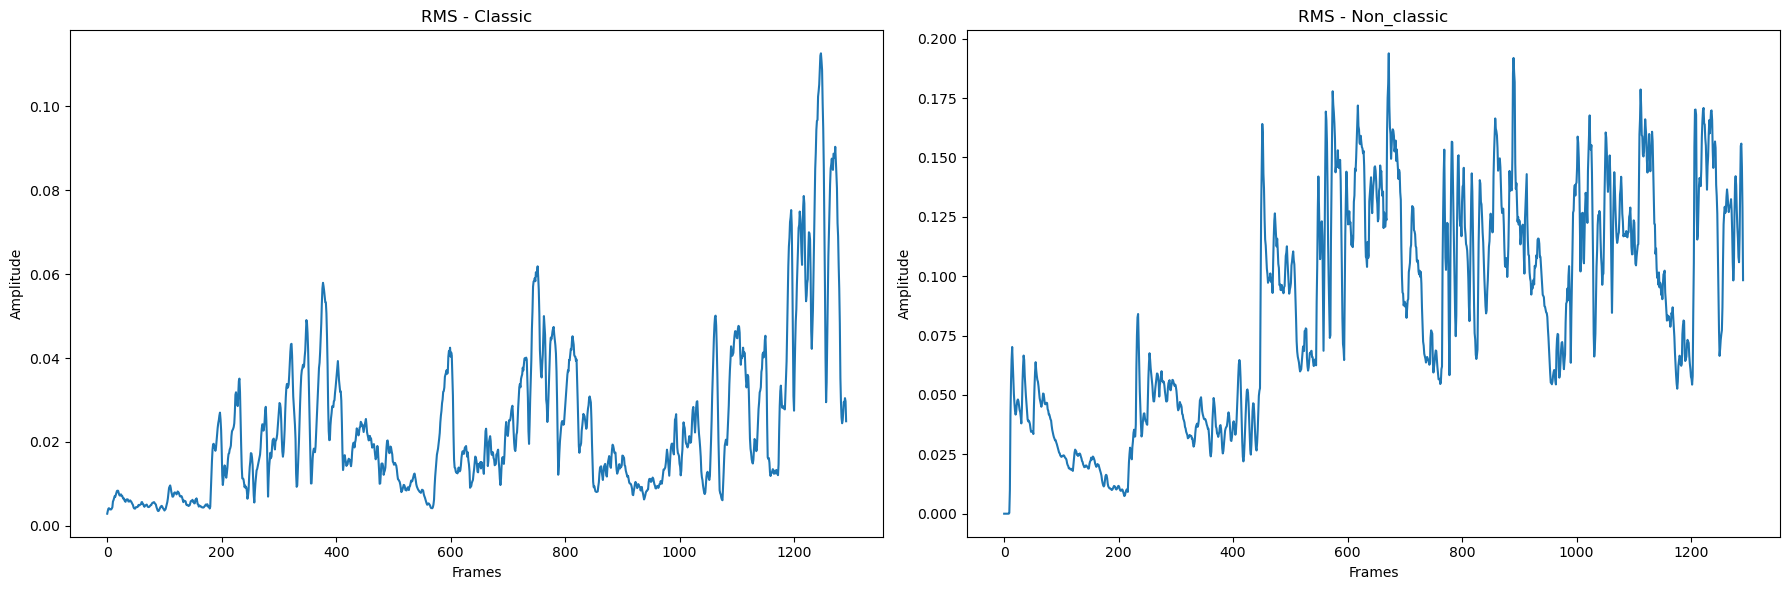

In [4]:
# Carga de datos de anotaciones y selección de un audio por categoría
df = pd.read_csv('ccmusic/train/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(18, 6))  # Ajusta el tamaño general del gráfico

for index, row in selected_files.iterrows():
    file_name = f'{row["audio_file"]}'
    label = row['label_name']
    audio_data, sr = librosa.load(file_name, sr=None)
    rms = librosa.feature.rms(y=audio_data)

    plt.subplot(1, 2, index+1)
    plt.plot(rms[0])
    plt.title(f'RMS - {label}')
    plt.xlabel('Frames')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

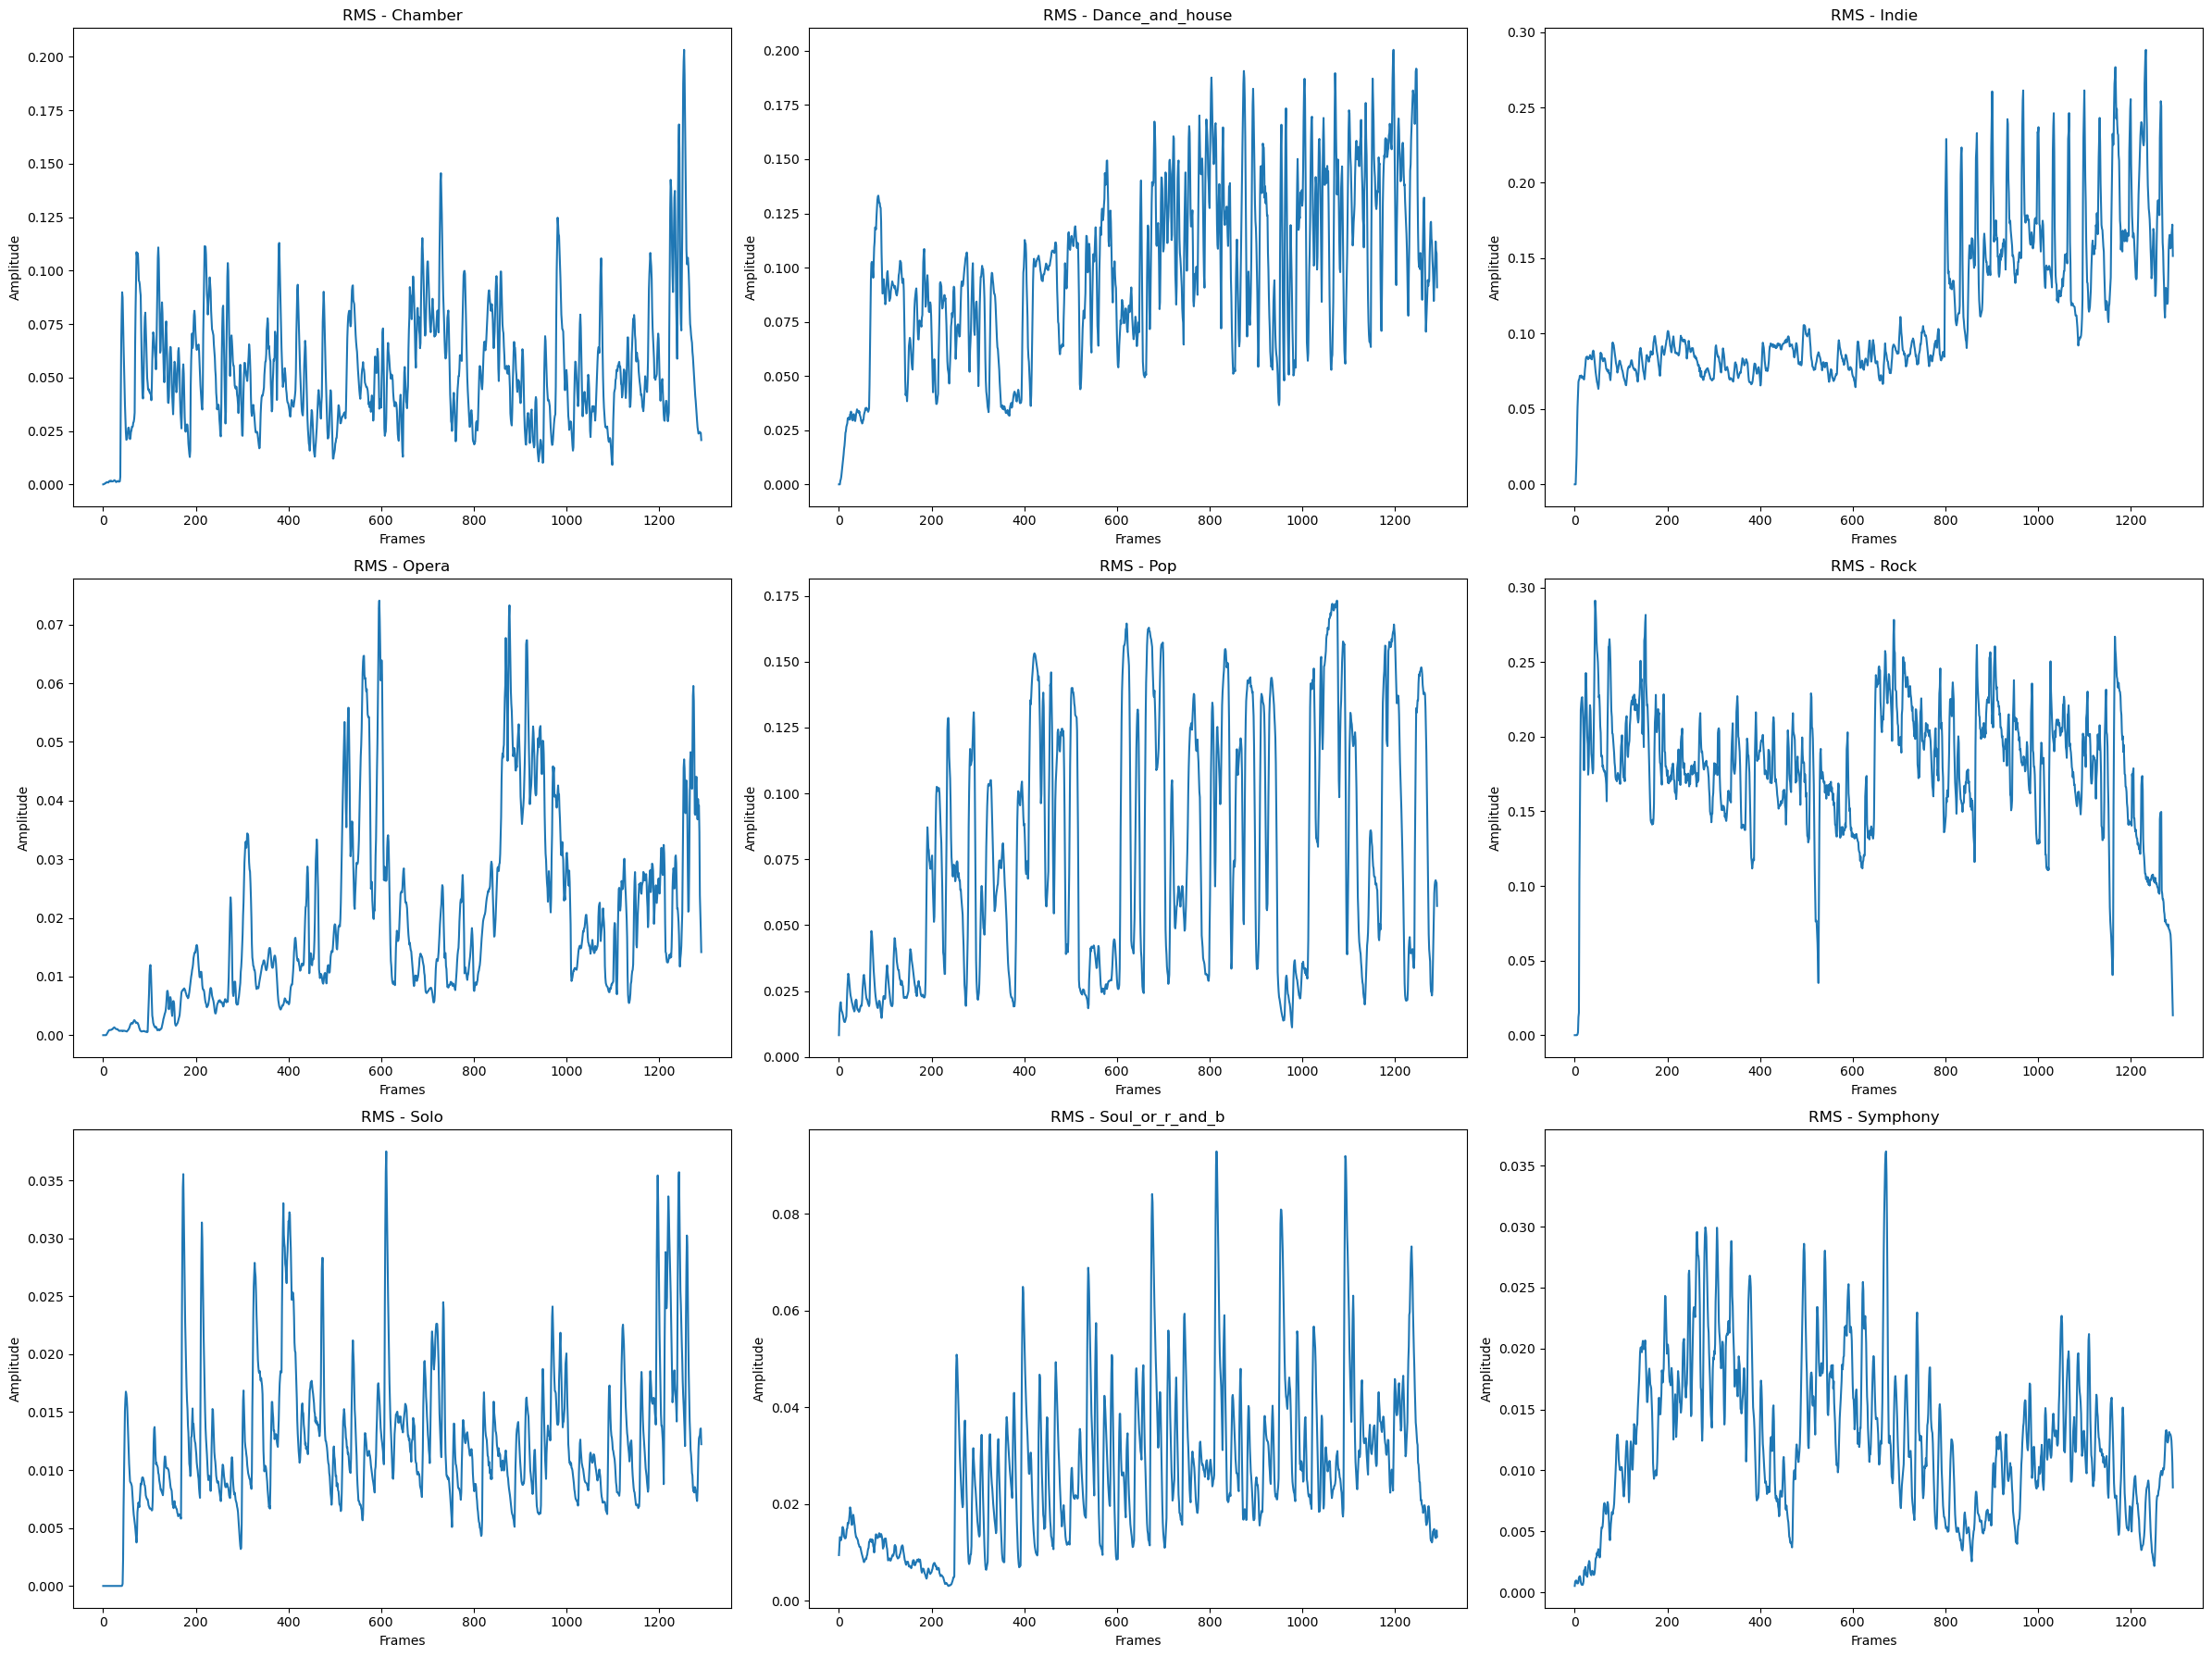

In [8]:
# Carga de datos de anotaciones y selección de un audio por categoría
df = pd.read_csv('ccmusic2/train/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(24, 18))  # Ajusta el tamaño general del gráfico

for index, row in selected_files.iterrows():
    file_name = f'{row["audio_file"]}'
    label = row['label_name']
    audio_data, sr = librosa.load(file_name, sr=None)
    rms = librosa.feature.rms(y=audio_data)

    plt.subplot(3, 3, index+1)
    plt.plot(rms[0])
    plt.title(f'RMS - {label}')
    plt.xlabel('Frames')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

## ZCR

La ZCR (Zero Crossing Rate) mide cuantas veces la señal de audio cruza el eje horizontal respecto a la longitud total de la señal., es decir, cuantas veces la amplitud pasa de negativa a positiva o viceversa.

Para calcular la ZCR de una señal $s(i)$ segmentada en $k$ bloques de tamaño $F$, se calcula:

$$ZCR_k=\sum_{i=k \cdot F}^{(k+1)\cdot F-1} \frac{1}{2} | \text{sgn($s(i)$)- sgn($s(i+1)$)}  |$$
donde la funcion signo se define: 

$$ \text{sgn($z$)}=\begin{Bmatrix} 
      1  &  z>0 \\
      0  &  z=0 \\
      -1 &  z<0
      \end{Bmatrix}$$

El resultado para cada bloque puede ser normalizado $ZCR_k/F$ para que sus valores estén entre [0,1]

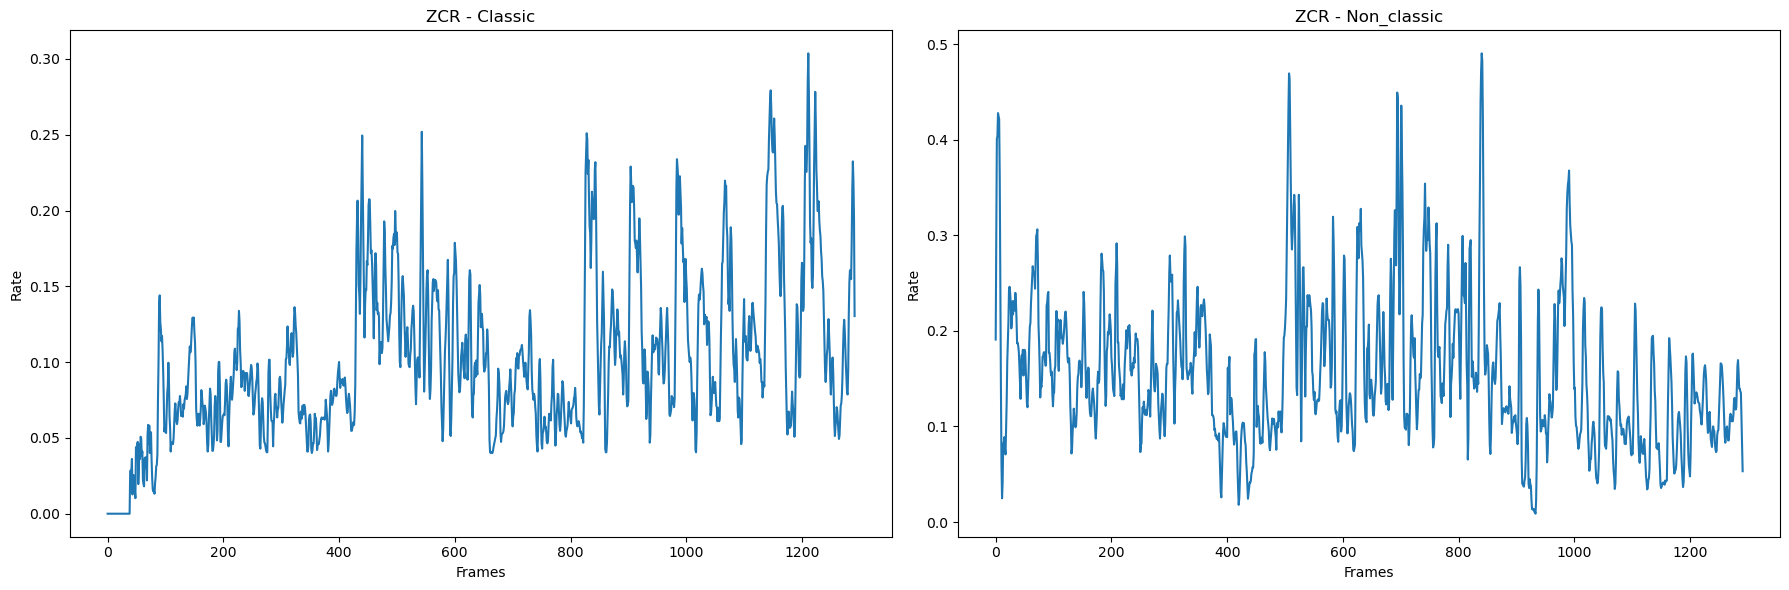

In [9]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Carga de datos de anotaciones y selección de un audio por categoría
df = pd.read_csv('ccmusic/train/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(18, 6))  # Ajusta el tamaño general del gráfico

for index, row in selected_files.iterrows():
    file_name = f'{row["audio_file"]}'
    label = row['label_name']
    audio_data, sr = librosa.load(file_name, sr=None)
    zcr = librosa.feature.zero_crossing_rate(y=audio_data)

    plt.subplot(1, 2, index+1)
    plt.plot(zcr[0])
    plt.title(f'ZCR - {label}')
    plt.xlabel('Frames')
    plt.ylabel('Rate')

plt.tight_layout()
plt.show()

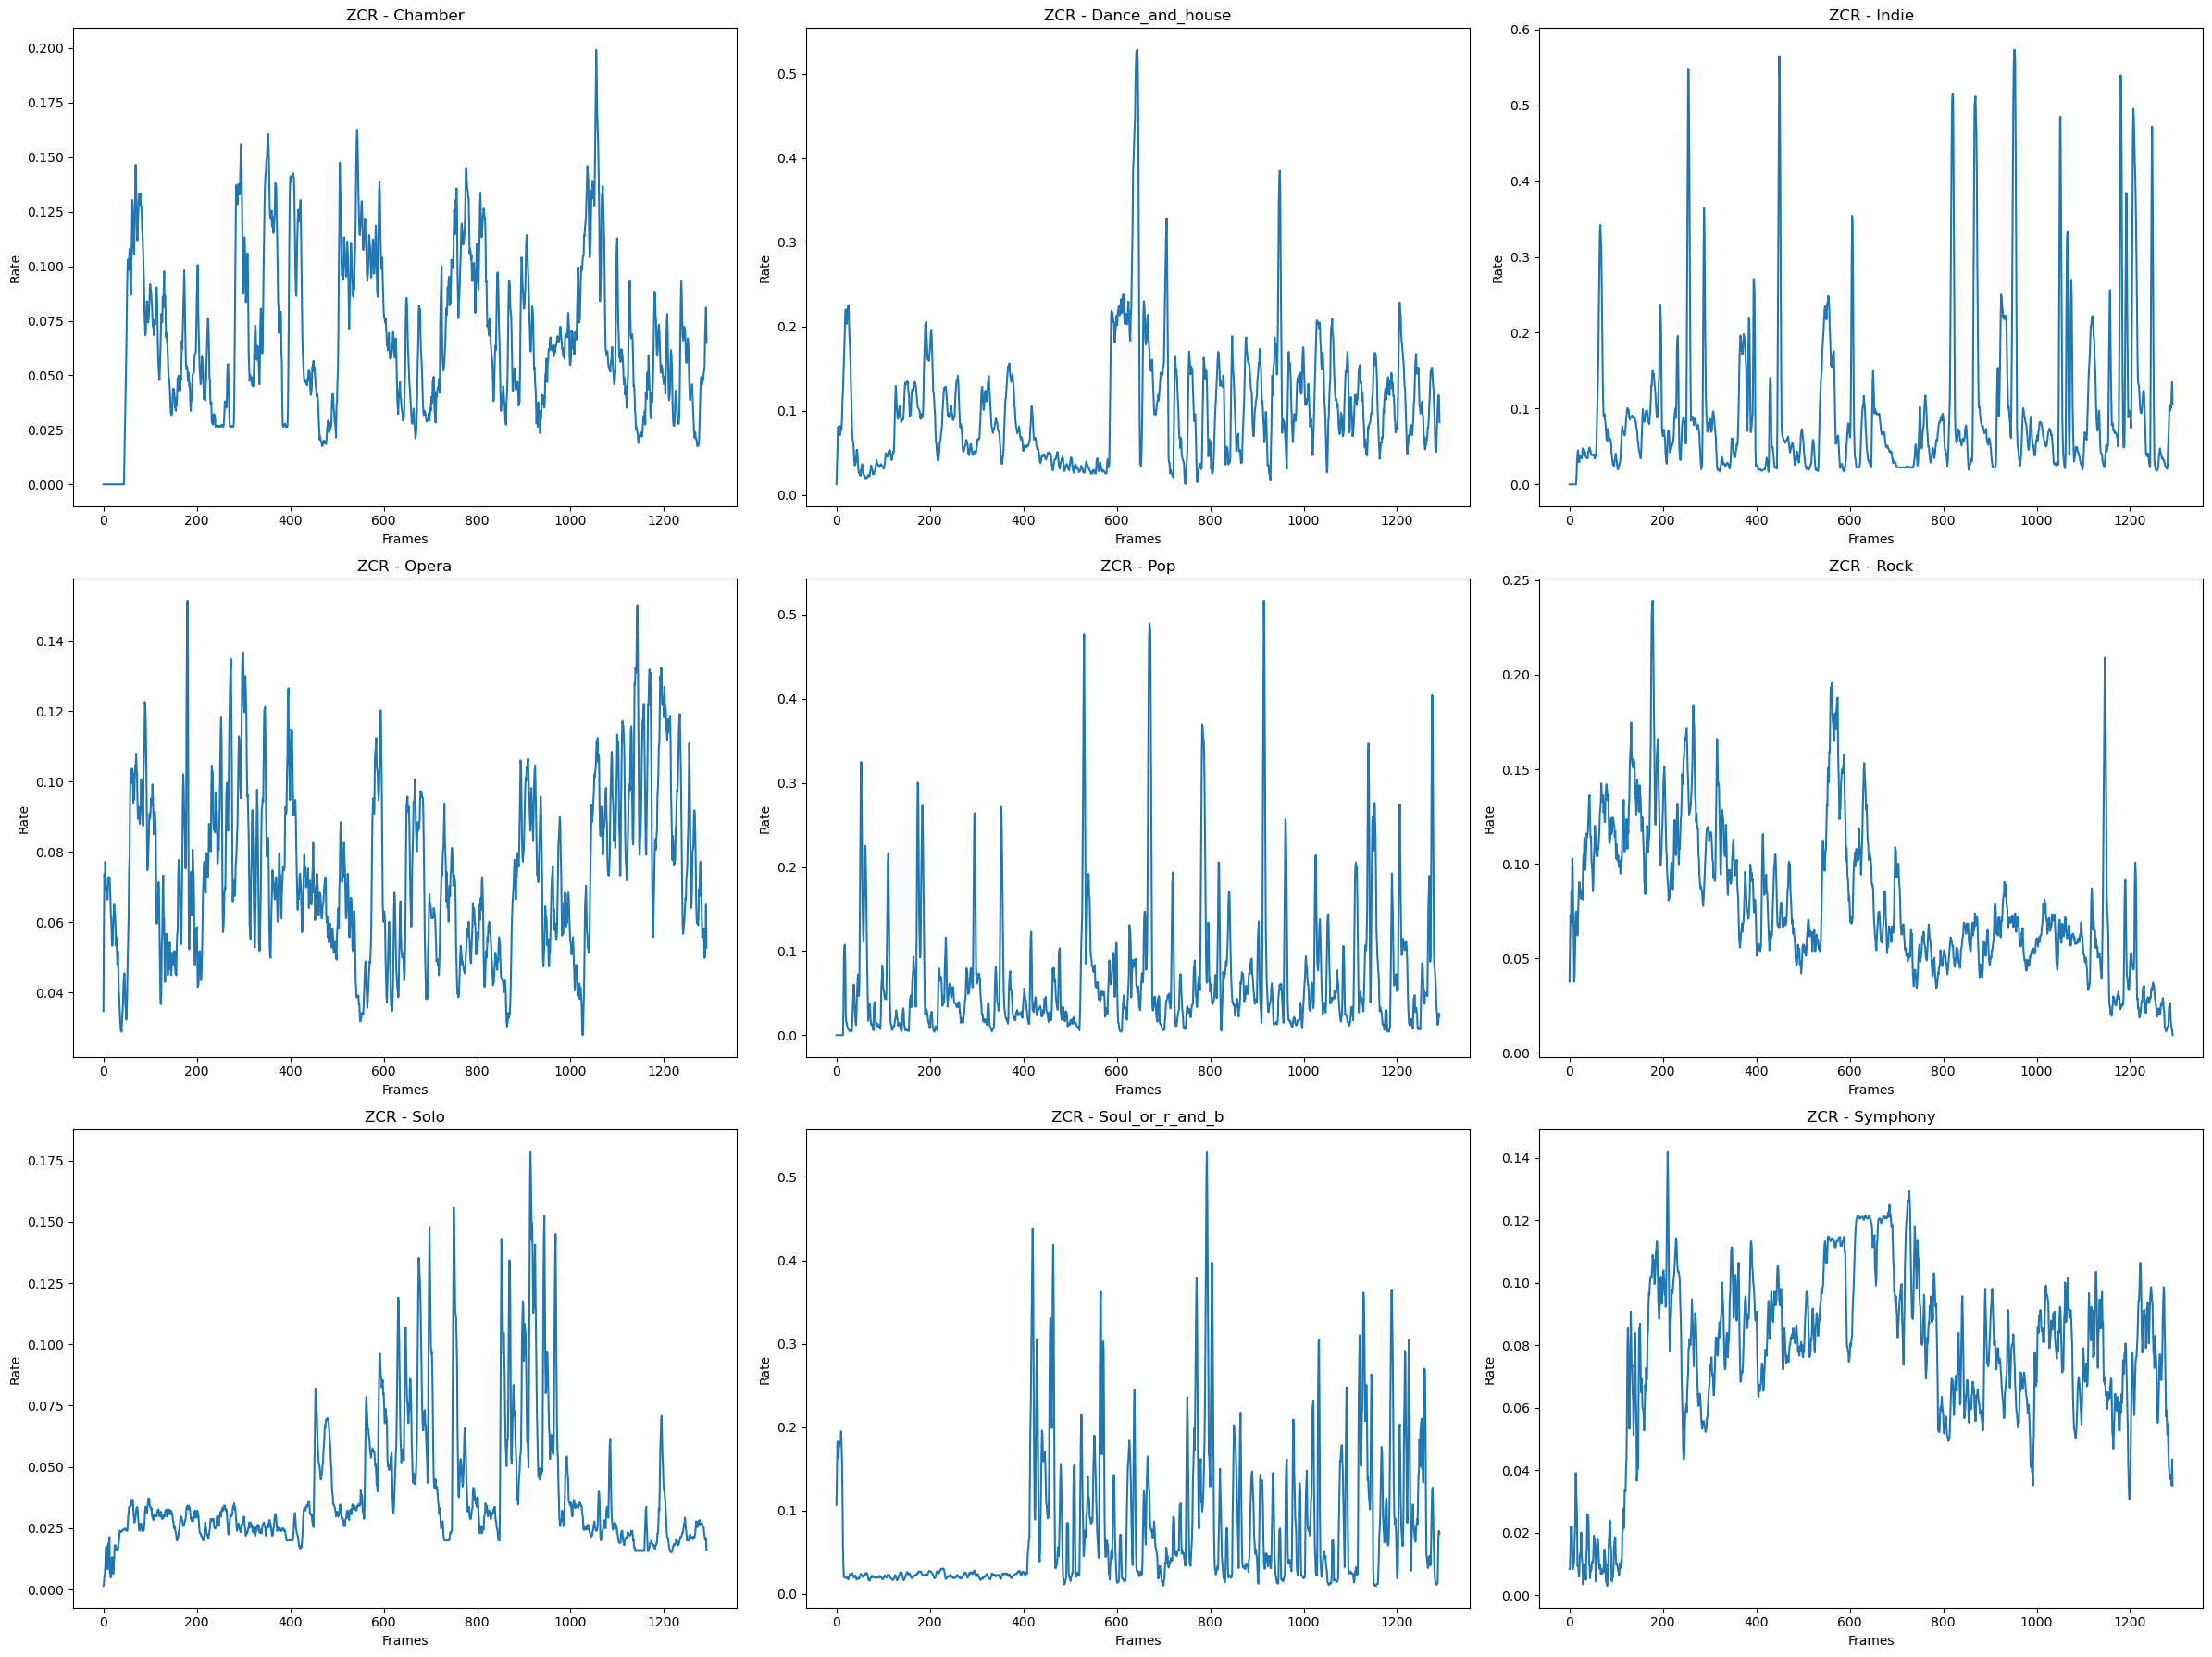

In [10]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Carga de datos de anotaciones y selección de un audio por categoría
df = pd.read_csv('ccmusic2/train/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(24, 18))  # Ajusta el tamaño general del gráfico

for index, row in selected_files.iterrows():
    file_name = f'{row["audio_file"]}'
    label = row['label_name']
    audio_data, sr = librosa.load(file_name, sr=None)
    zcr = librosa.feature.zero_crossing_rate(y=audio_data)

    plt.subplot(3, 3, index+1)
    plt.plot(zcr[0])
    plt.title(f'ZCR - {label}')
    plt.xlabel('Frames')
    plt.ylabel('Rate')

plt.tight_layout()
plt.show()

## Chroma STFT

El Chroma STFT (Short-Time Fourier Transform) es una característica que representa la intensidad de las doce diferentes clases de tonos (notas musicales) en cada ventana de tiempo de una señal de audio. Esta técnica es esencialmente útil para analizar la música donde las dimensiones armónicas y melódicas son más relevantes. Utiliza la transformada de Fourier de tiempo corto para primero transformar la señal de tiempo a frecuencia y luego mapear esas frecuencias en 12 regiones que corresponden a las 12 notas de la escala cromática occidental.

Para calcular el Chroma STFT de una señal \(s(t)\), primero se realiza una transformada de Fourier de tiempo corto para obtener la representación en frecuencia de ventanas sucesivas de la señal:

$$ X(k, \omega) = \sum_{n=0}^{N-1} s(n + kH) \cdot w(n) \cdot e^{-j \omega n} $$

donde:
- $ k $ es el índice de la ventana temporal
- $ H $ es el tamaño del salto entre ventanas consecutivas
- $ w(n) $ es la ventana de análisis aplicada a la señal
- $ N $ es el número de puntos en la FFT
- $ \omega $ es la frecuencia angular

Después, se mapea la magnitud del espectro obtenido $  |X(k, \omega)| $ a las 12 clases cromáticas utilizando un algoritmo que suma la energía de las frecuencias que caen dentro de cada clase tonal. Estas clases están divididas según la afinación temperada de los tonos musicales, que divide la octava en 12 tonos de igual razón de frecuencias. El resultado se normaliza y se convierte en un vector de 12 componentes que indica la fuerza relativa de cada clase tonal a lo largo del tiempo:

$$ C(k, m) = \sum_{\omega \in \text{bin}(m)} |X(k, \omega)| $$

donde:
- \(m\) es el índice de una de las 12 clases cromáticas,
- \(\text{bin}(m)\) es el conjunto de índices de frecuencia que corresponden a la clase tonal \(m\) en la escala temperada.

El resultado, $ C(k, m) $, representa la intensidad de cada nota cromática en cada segmento de tiempo de la señal, proporcionando una potente herramienta para el análisis armónico y melódico en música.

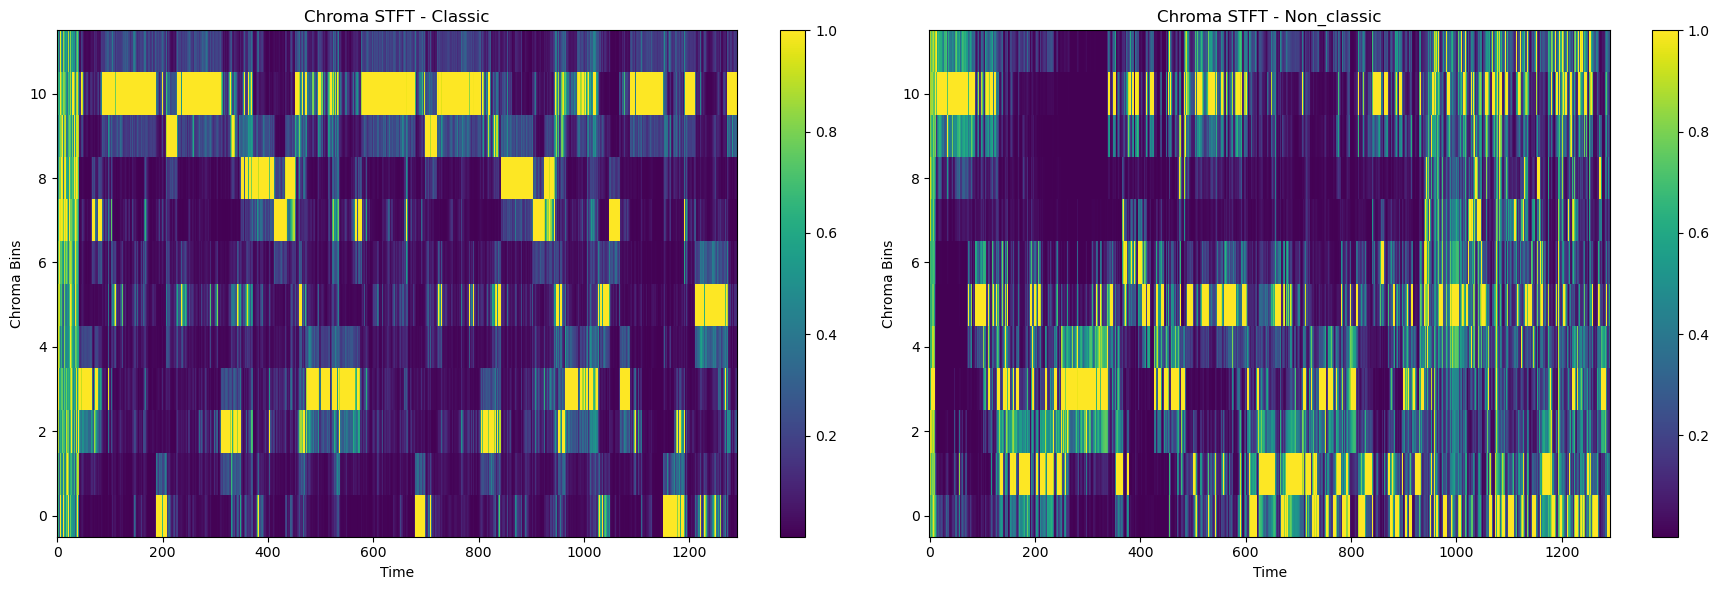

In [11]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Carga de datos de anotaciones y selección de un audio por categoría
df = pd.read_csv('ccmusic/train/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(18, 6))  # Ajusta el tamaño general del gráfico

for index, row in selected_files.iterrows():
    file_name = f'{row["audio_file"]}'
    label = row['label_name']
    audio_data, sr = librosa.load(file_name, sr=None)
    chroma_stft = librosa.feature.chroma_stft(y=audio_data, sr=sr)

    plt.subplot(1, 2, index+1)
    plt.imshow(chroma_stft, aspect='auto', origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Chroma STFT - {label}')
    plt.xlabel('Time')
    plt.ylabel('Chroma Bins')

plt.tight_layout()
plt.show()

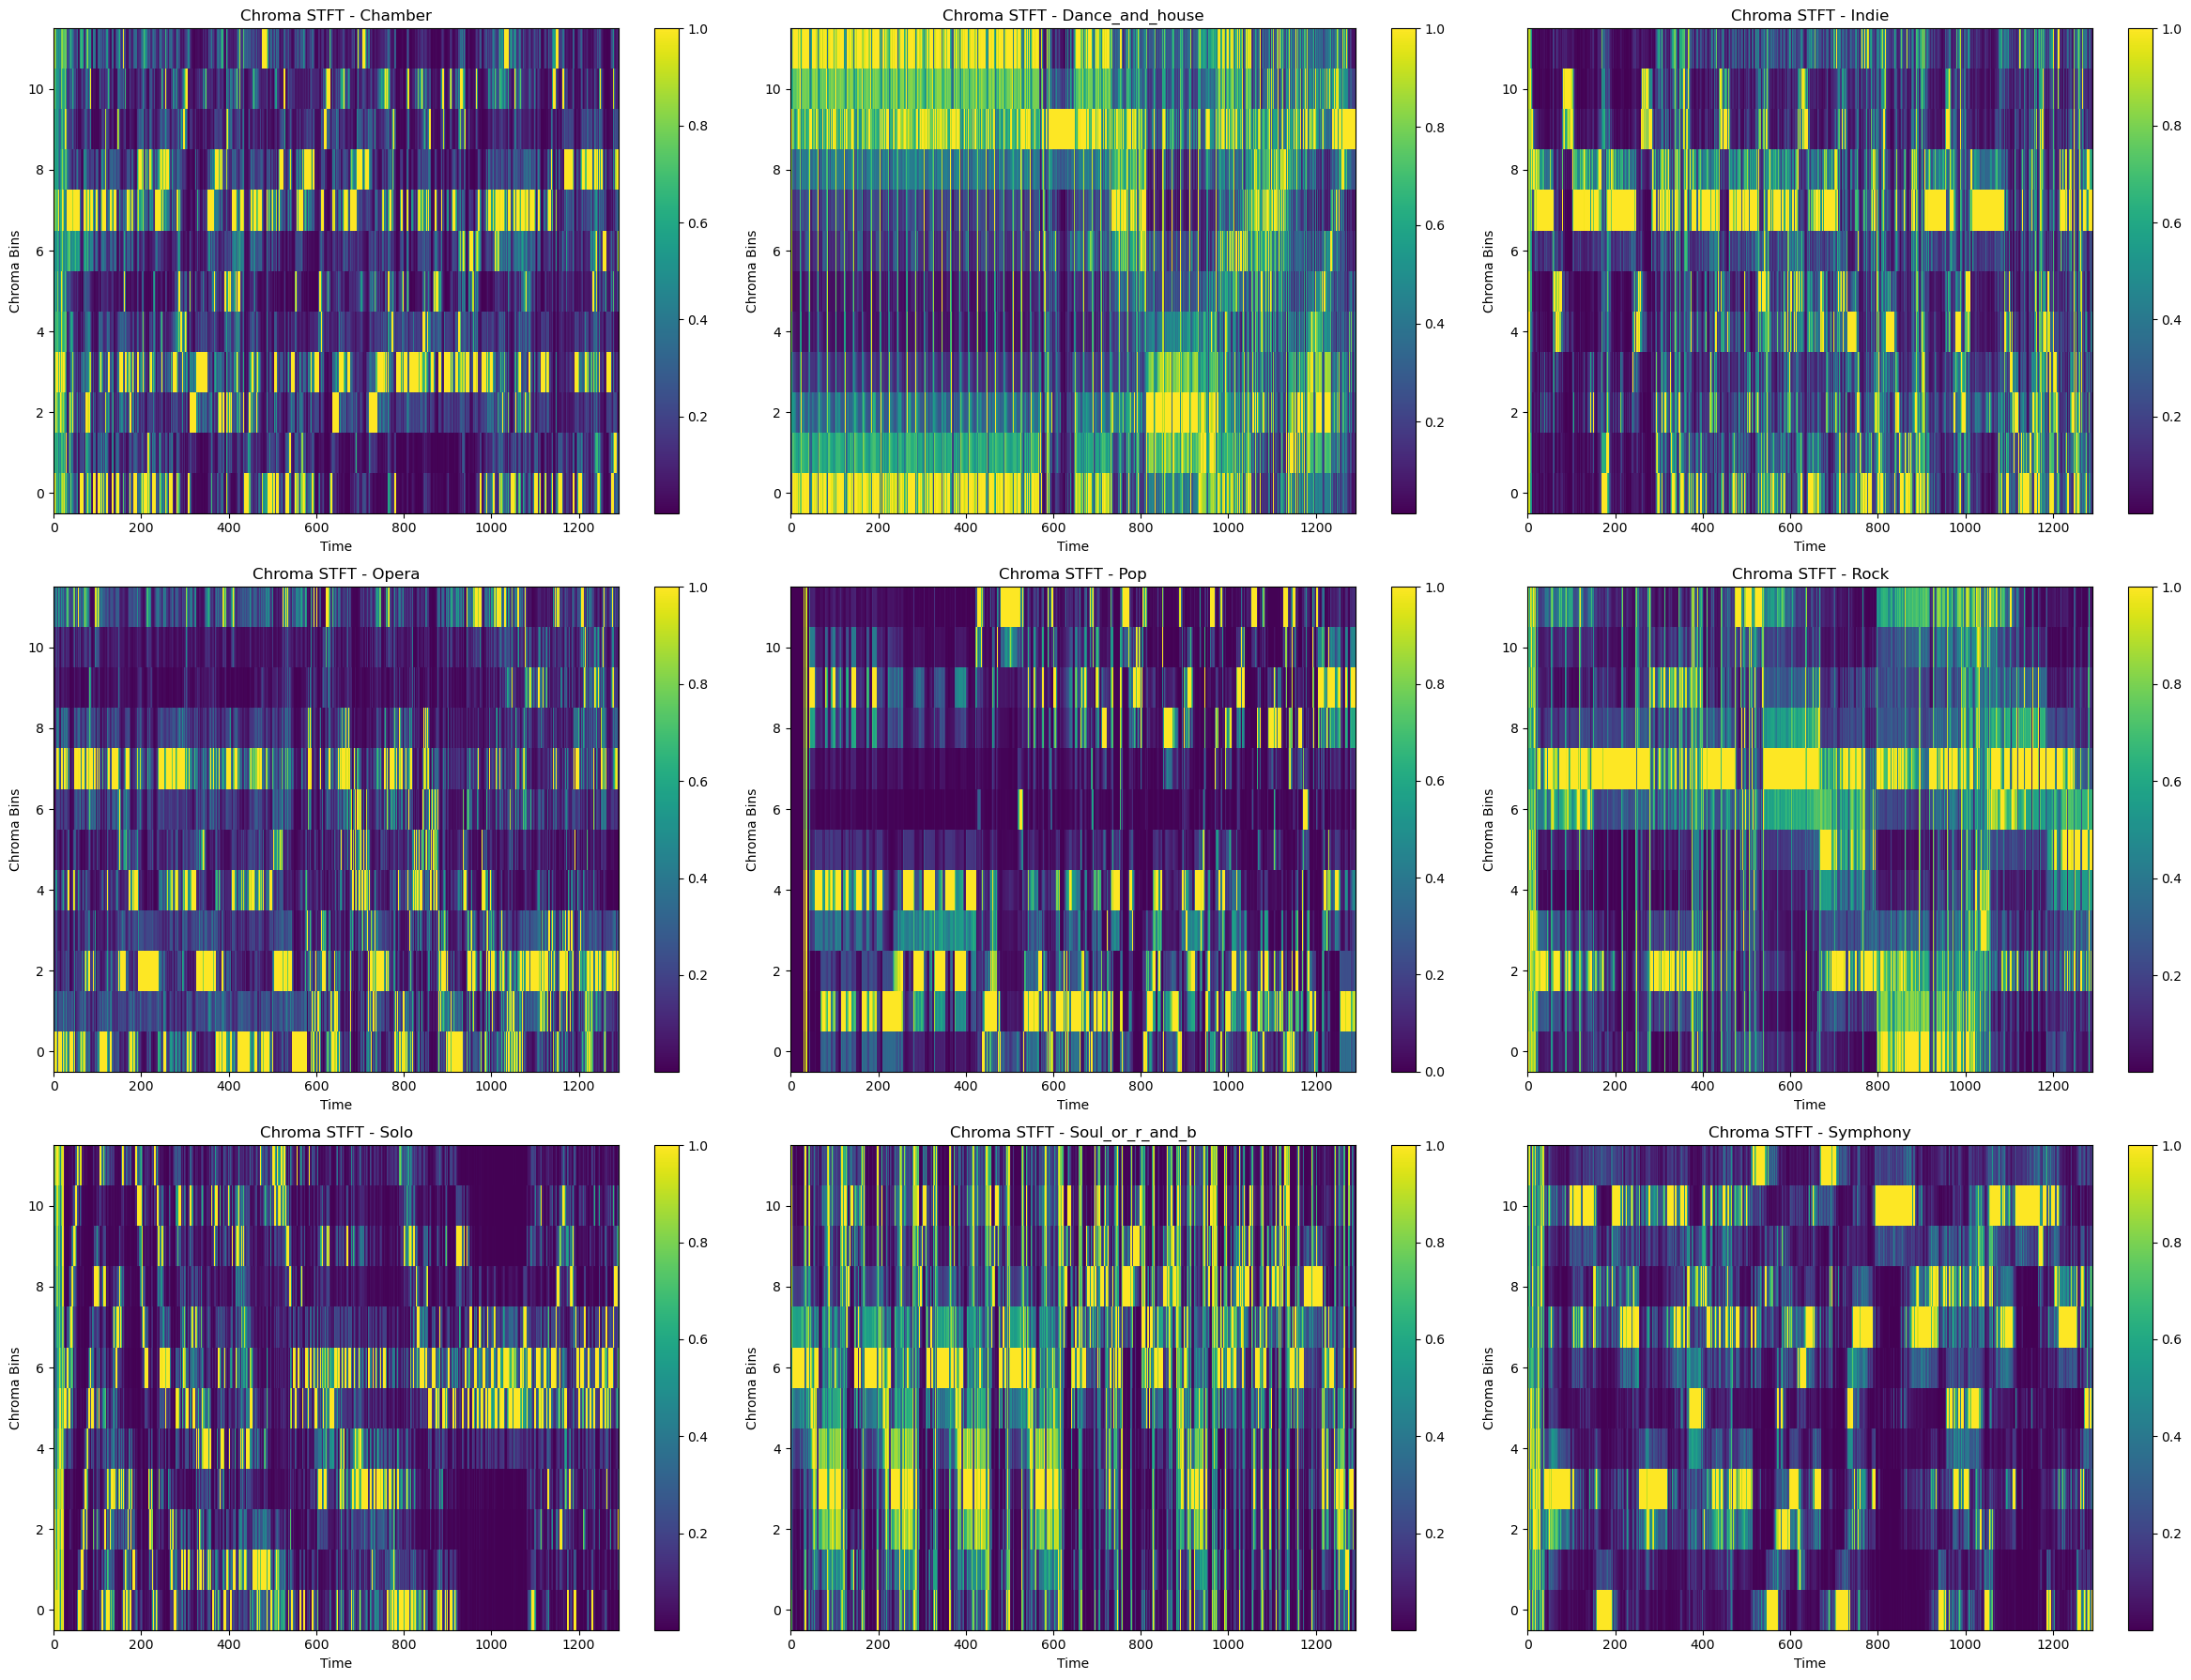

In [12]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Carga de datos de anotaciones y selección de un audio por categoría
df = pd.read_csv('ccmusic2/train/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(24, 18))  # Ajusta el tamaño general del gráfico

for index, row in selected_files.iterrows():
    file_name = f'{row["audio_file"]}'
    label = row['label_name']
    audio_data, sr = librosa.load(file_name, sr=None)
    chroma_stft = librosa.feature.chroma_stft(y=audio_data, sr=sr)

    plt.subplot(3, 3, index+1)
    plt.imshow(chroma_stft, aspect='auto', origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Chroma STFT - {label}')
    plt.xlabel('Time')
    plt.ylabel('Chroma Bins')

plt.tight_layout()
plt.show()

## Spectral Rolloff

El Spectral Rolloff es una medida del espectro de una señal de audio y representa el punto por debajo del cual se encuentra un cierto porcentaje de la energía total del espectro. Típicamente, este umbral se establece en el 85% pero puede ajustarse según sea necesario. El Spectral Rolloff es útil para determinar el límite superior de las frecuencias presentes en una señal, proporcionando una buena indicación de la presencia de altas frecuencias.

Para calcular el Spectral Rolloff de una señal $ s(t) $ a lo largo de ventanas temporales sucesivas, primero se realiza una transformada de Fourier de tiempo corto para obtener la representación en frecuencia de la señal:

$$ X(k, \omega) = \sum_{n=0}^{N-1} s(n + kH) \cdot w(n) \cdot e^{-j \omega n} $$

donde:
- $ k $ es el índice de la ventana temporal
- $ H $ es el tamaño del salto entre ventanas consecutivas
- $ w(n) $ es la ventana de análisis aplicada a la señal
- $ N $ es el número de puntos en la FFT
- $ \omega $ es la frecuencia angular

A partir de la magnitud del espectro obtenido $ |X(k, \omega)| $, se calcula el rolloff como la frecuencia mínima para la cual la suma acumulada de la magnitud del espectro excede el 85% (u otro porcentaje especificado) del total de la energía espectral en esa ventana:

$$ R(k) = \min \left( \omega : \sum_{i=0}^{\omega} |X(k, i)| \geq 0.85 \times \sum_{i=0}^{N-1} |X(k, i)| \right) $$

donde:
- $ R(k) $ es el valor de rolloff para la ventana \(k\)
- $ |X(k, i)| $ es la magnitud del espectro en la frecuencia \(i\)
- $ N-1 $ es el índice de la frecuencia más alta en la FFT.

El Spectral Rolloff proporciona una característica valiosa para análisis de contenido musical, especialmente en la diferenciación entre música más orientada a bajos y música que contiene elementos de frecuencias altas más prominentes.

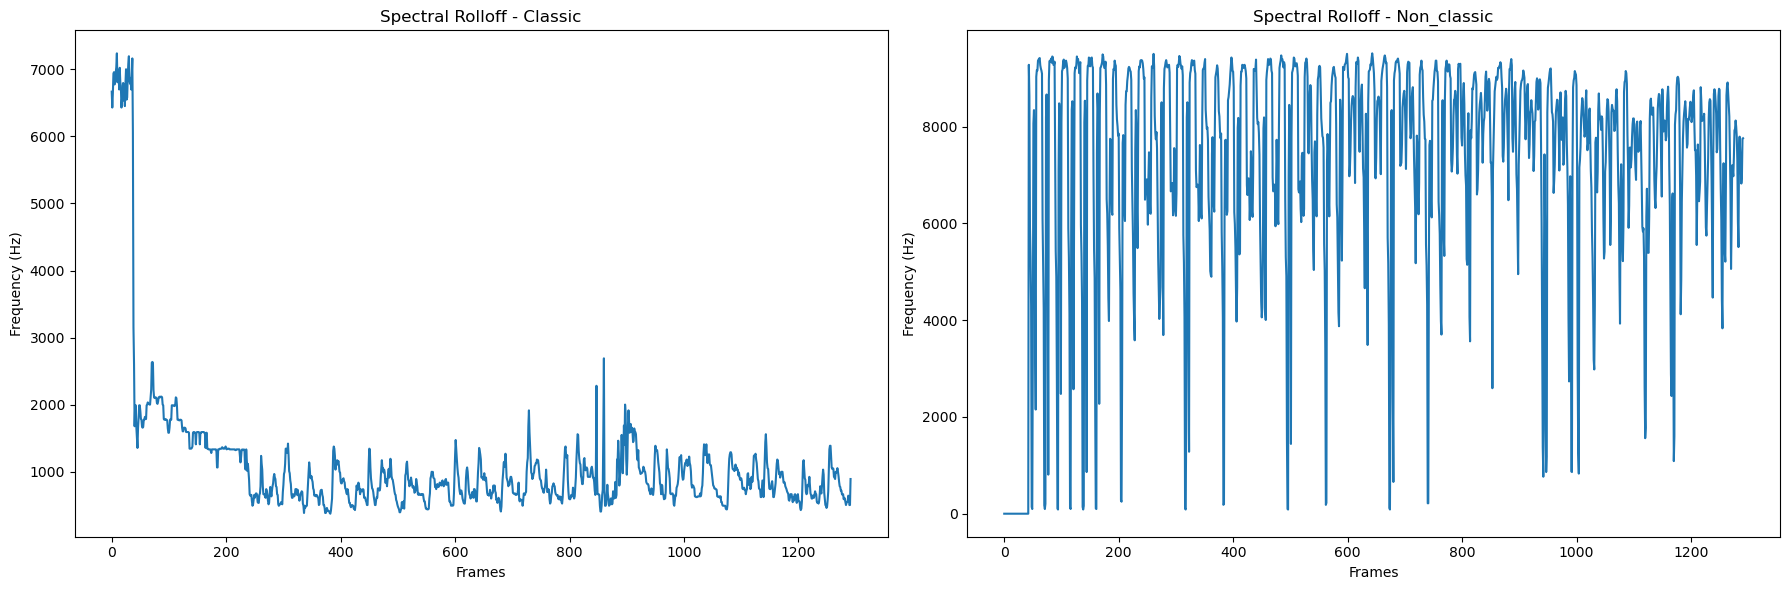

In [17]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Carga de datos de anotaciones y selección de un audio por categoría
df = pd.read_csv('ccmusic/train/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(18, 6))  # Ajusta el tamaño general del gráfico

for index, row in selected_files.iterrows():
    file_name = f'{row["audio_file"]}'
    label = row['label_name']
    audio_data, sr = librosa.load(file_name, sr=None)
    rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)

    plt.subplot(1, 2, index+1)
    plt.plot(rolloff[0])
    plt.title(f'Spectral Rolloff - {label}')
    plt.xlabel('Frames')
    plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

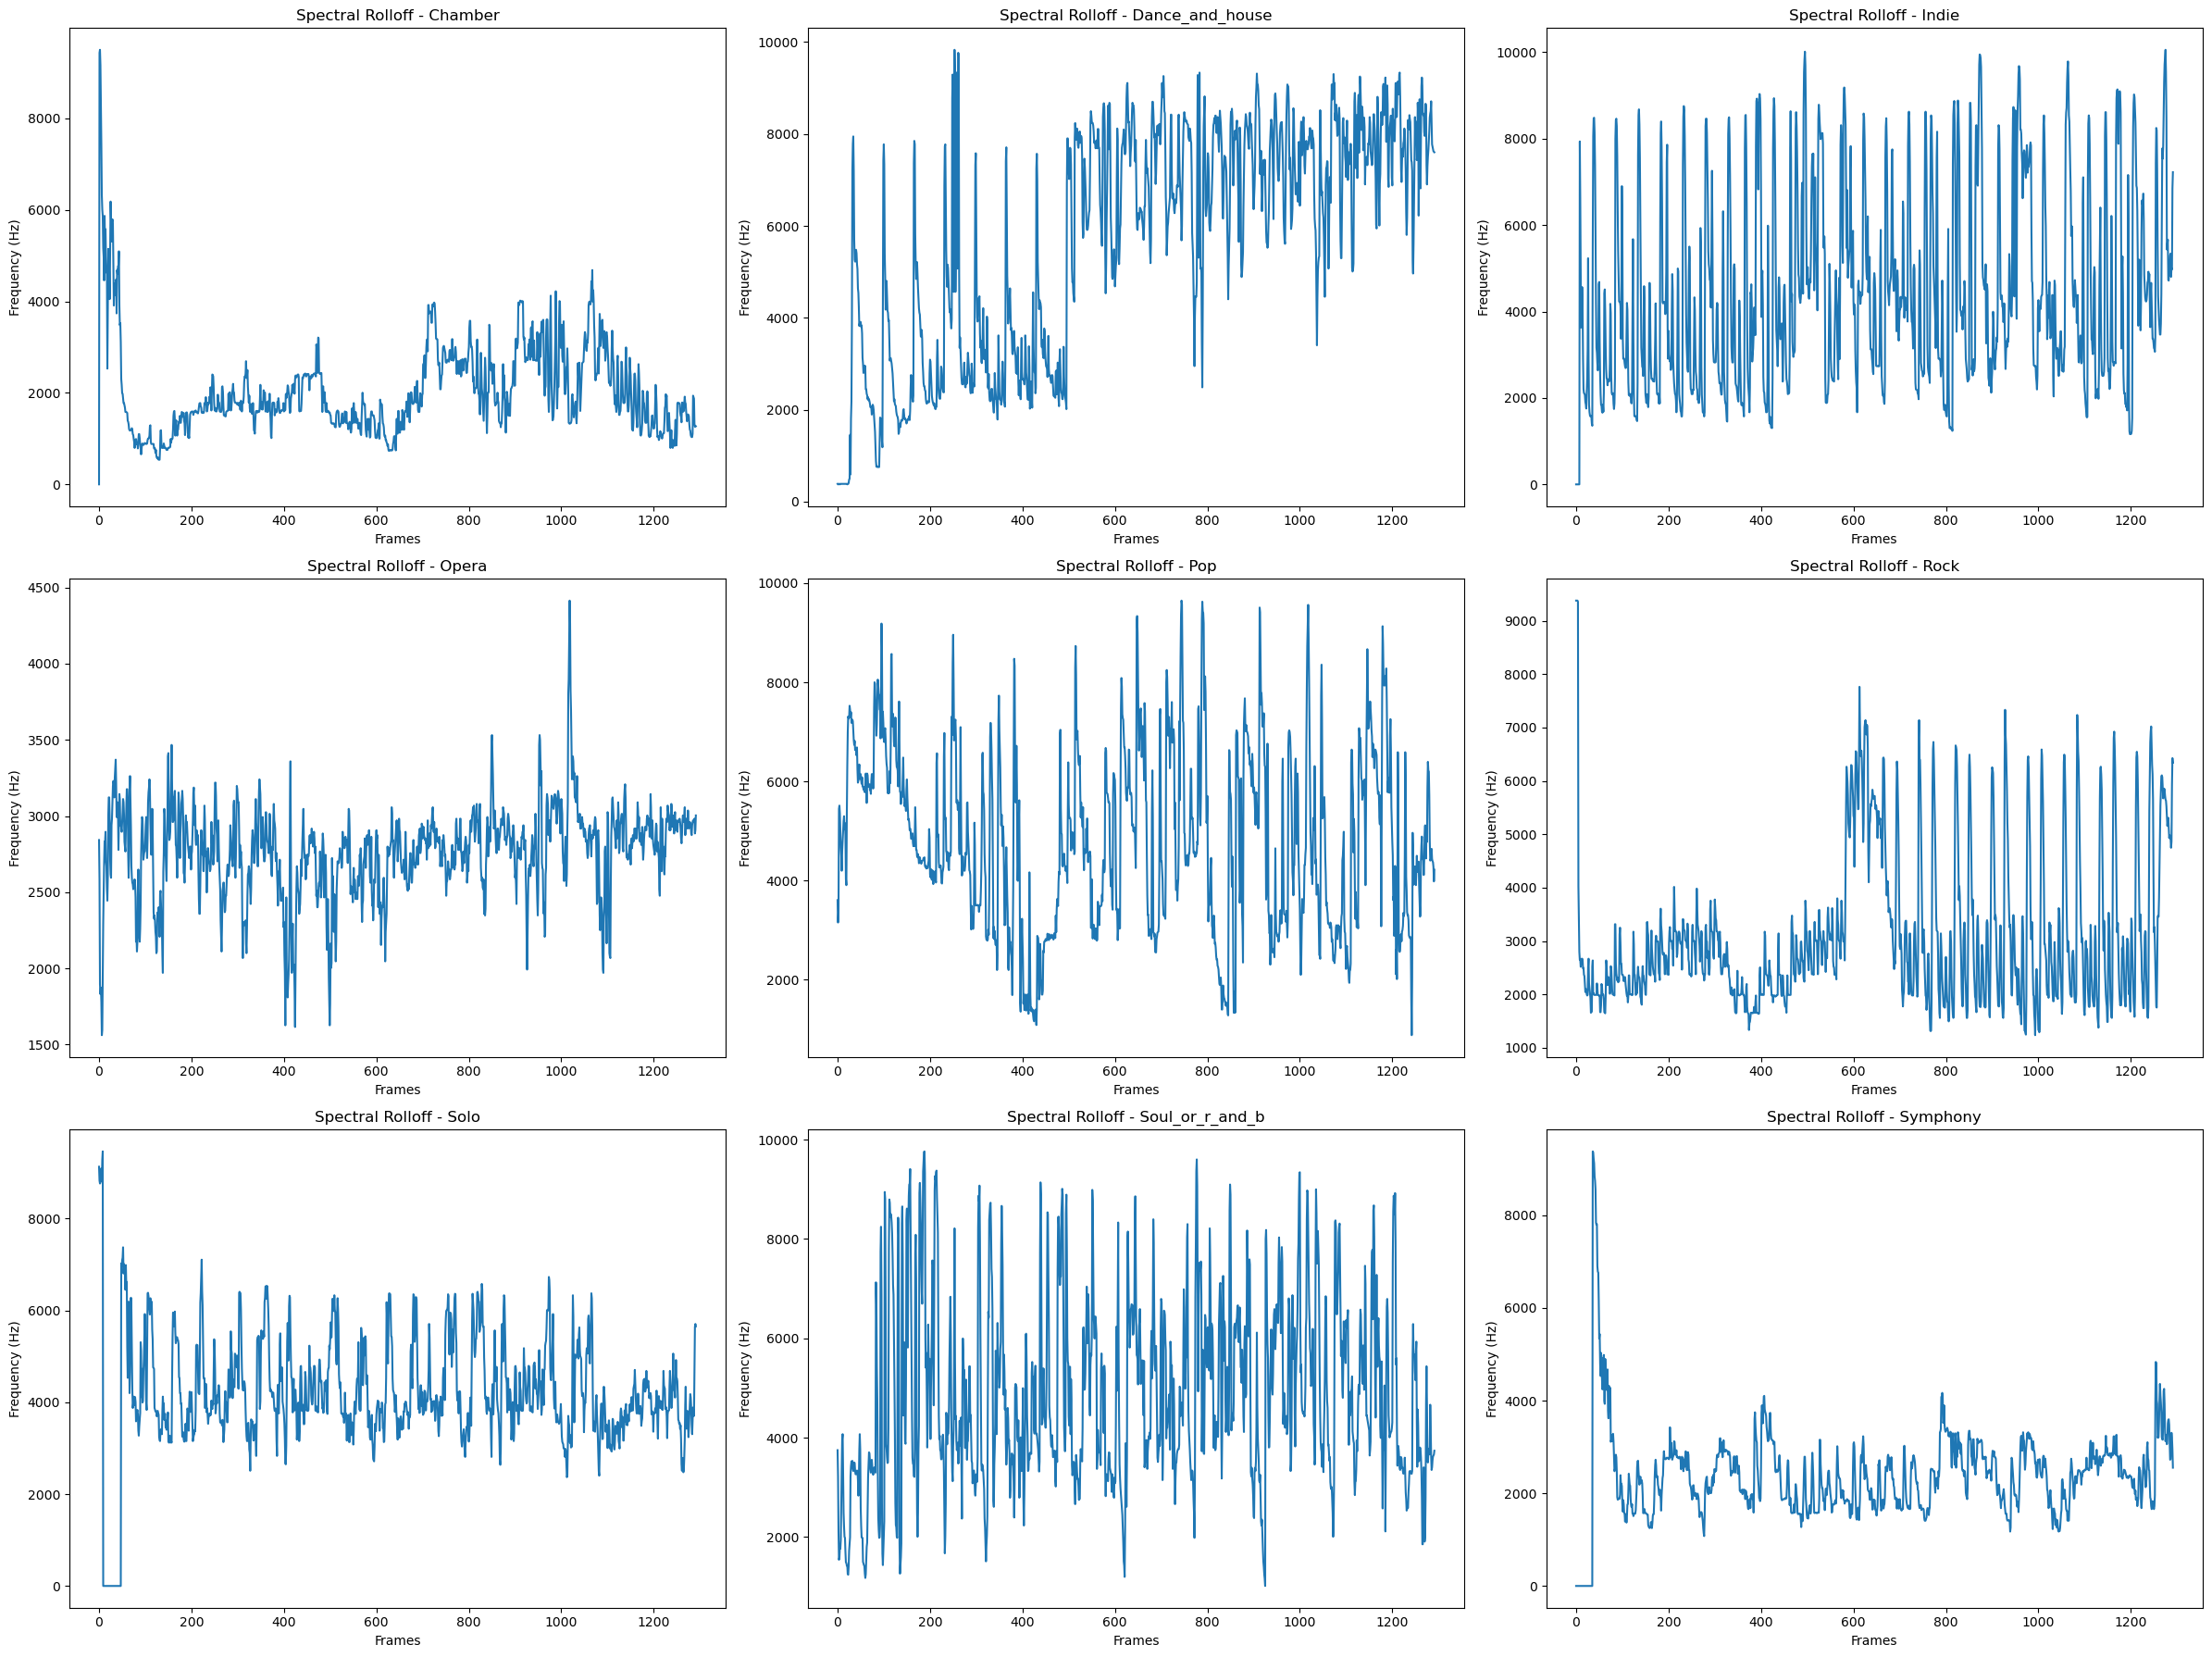

In [18]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Carga de datos de anotaciones y selección de un audio por categoría
df = pd.read_csv('ccmusic2/train/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(24, 18))  # Ajusta el tamaño general del gráfico

for index, row in selected_files.iterrows():
    file_name = f'{row["audio_file"]}'
    label = row['label_name']
    audio_data, sr = librosa.load(file_name, sr=None)
    rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)

    plt.subplot(3, 3, index+1)
    plt.plot(rolloff[0])
    plt.title(f'Spectral Rolloff - {label}')
    plt.xlabel('Frames')
    plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

____

## 2.3. Extracción de características para el dataset CCMUSIC

En la actualidad es muy común el uso de espectogramas junto con redes convolucionales CNN para realizar clasificación de audio. No obstante, tradicionalmente, para entrenar modelos clásicos de Machine Learning se utilizaba extracción de características.

Al igual que en el caso del análisis de textos se utilizada el TfIdf junto con SVM ("bag of words"), en el análisis de audio se identificaba cada audio con una serie de características y se construía un dataset tabular (de ahí que hayamos titulado este proyecto "bag of songs").

En esta sección, vamos a extraer las características anteriores para cada audio y vamos a construir un dataset tabular que nos permita clasificar utilizando modelos clásicos y datos tabulares.

____